In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from scipy.optimize import curve_fit
from math import exp

# Extracellular metabolomics

In [2]:
growth_fixed = pd.read_excel('../data/Exp_data/Growth_pHcontrol_B.xlsx')
metab = pd.read_csv('../data/Exp_data/Metabolomics_mM.csv')
conv_factor = 0.35 # gDW/L : OD600 Reference:  https://doi.org/10.1111/j.1472-765X.2009.02752.x
def get_grs(od_list, time_step):
    output = []
    for i in range(len(od_list)-1):
        output.append( np.log(od_list[i+1]/od_list[i]) /time_step )
    return output  

def norm_rates(biomass, cons, time_step):
    output = []
    for i in range(len(biomass)-1):
        output.append( ((cons[i+1]-cons[i])/(biomass[i]/2+biomass[i+1]/2) )/time_step )
    return output

In [3]:
# def plot_met(met, metab_table, ax):
#     metab = metab_table
#     for cond in ['pH4.5', 'pH5', 'pH5.5', 'pH6.5']:
#         temp_pd = (metab[metab['Sample']==cond]).reset_index().drop(['index'],axis=1)
#         if cond == 'pH4.5':
#             avg = list(temp_pd[met+'(avg)'])[:5] + list(temp_pd[met+'(avg)'])[-2:]
#             std = list(temp_pd[met+'(std)'])[:5] + list(temp_pd[met+'(std)'])[-2:]
#             Time = list(temp_pd['Time'])[:5] + list(temp_pd['Time'])[-2:]
#             ax.errorbar(Time, avg, yerr= std,linestyle='dotted', elinewidth=2, label=cond )
#             ax.scatter(Time,avg, s=20)
#         else:
#             avg, std = temp_pd[met+'(avg)'], temp_pd[met+'(std)']
#             ax.errorbar(temp_pd['Time'],avg, yerr= std,linestyle='dotted', elinewidth=2, label=cond )
#             ax.scatter(temp_pd['Time'],avg, s=20)
#     ax.set_ylabel(met+'(mM)')
#     ax.set_xlabel('Time(hr)')
#     ax.legend()
#     ax.grid()

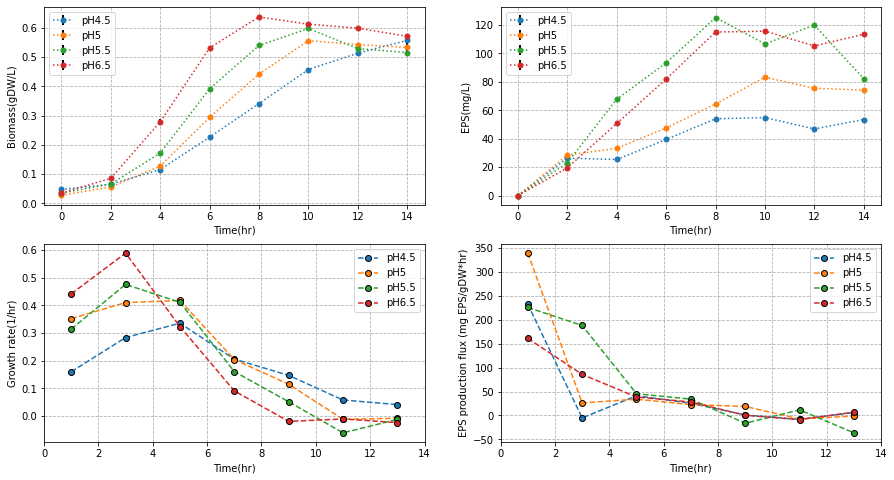

In [4]:
max_grs={}
max_EPS_rates ={}
fig, axs = plt.subplots(2,2, figsize=(15,8))
for x in [4.5, 5, 5.5, 6.5]:
    temp_pd = (growth_fixed[growth_fixed['pH']==x]).reset_index().drop(['index'],axis=1)
    biomass = np.mean( temp_pd.iloc[:,2:5].values, axis=1) * conv_factor
    biomass_err = np.std( temp_pd.iloc[:,2:5].values, axis=1)*conv_factor
    grs = get_grs(biomass, 2)
    eps = np.mean( temp_pd.iloc[:,5:].values, axis=1)
    eps_err = np.std( temp_pd.iloc[:,5:].values, axis=1)
    eps_rates = norm_rates(biomass, eps, 2)
    max_grs[x]=max(grs)
    max_EPS_rates[x]=max(eps_rates)
    
    axs[0][0].errorbar( np.arange(0,16,2), biomass, yerr= biomass_err, ecolor='black',
                       marker='o', markersize=5, linestyle='dotted', elinewidth=2, label='pH'+str(x) )
    axs[0][0].set_ylabel('Biomass(gDW/L)')
    axs[0][1].errorbar( np.arange(0,16,2), eps, yerr= eps_err, ecolor='black',
                       marker='o', markersize=5, linestyle='dotted', elinewidth=2, label='pH'+str(x) )
    axs[0][1].set_ylabel('EPS(mg/L)')
    axs[1][0].plot( np.arange(1,15,2), grs, marker='o', linestyle='--', 
                    markeredgecolor='black',label='pH'+str(x))
    axs[1][0].set_ylabel('Growth rate(1/hr)')
    axs[1][1].plot( np.arange(1,15,2), eps_rates, marker='o', linestyle='--', 
                   markeredgecolor='black',label='pH'+str(x) )
    axs[1][1].set_ylabel('EPS production flux (mg EPS/gDW*hr)')
    
    for i in range(2):
        for j in range(2):
            axs[i][j].legend(); axs[i][j].set_xlabel('Time(hr)');
            axs[i][j].set_xticks(np.arange(0,16,2))
            axs[i][j].grid(linestyle='--')
# plt.savefig('../../../../EPS_LP/Figures/growth_eps.svg',format='svg',dpi=150)

In [8]:
print(max_grs)
print(max_EPS_rates)

{4.5: 0.33518078911208254, 5: 0.41737210588433693, 5.5: 0.4753825089522112, 6.5: 0.5886210431486689}
{4.5: 232.0583306382854, 5: 338.5890799468476, 5.5: 225.26467128479936, 6.5: 160.84310034487967}


In [3]:
def get_met_cons(met, metab_table):
    metab = metab_table
    result = {'Time':[0,2,4,6,8,12,14]}
    for cond in ['pH4.5', 'pH5', 'pH5.5', 'pH6.5']:
        temp_pd = (metab[metab['Sample']==cond]).reset_index().drop(['index'],axis=1)
        avg = list(temp_pd[met+'(avg)'])[:5] + list(temp_pd[met+'(avg)'])[-2:]
        std = list(temp_pd[met+'(std)'])[:5] + list(temp_pd[met+'(std)'])[-2:]
        result[cond+'_avg'] = avg; result[cond+'_std'] =std
    return result

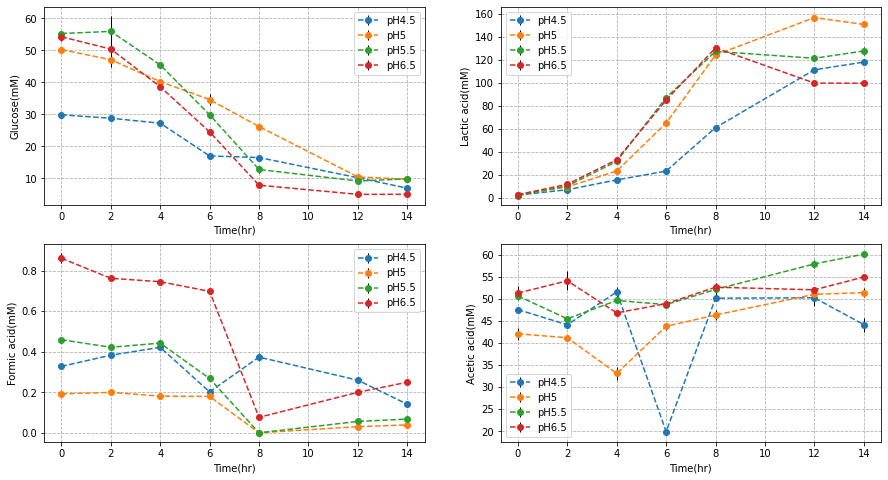

In [31]:
met_plots = ['Glucose', 'Lactic acid','Formic acid', 'Acetic acid']
conditions = ['pH4.5', 'pH5', 'pH5.5', 'pH6.5']
fig, axs = plt.subplots(2,2, figsize=(15,8))
for i in range(len(met_plots)):
    met = met_plots[i]
    x,y = int(i/2), int(i%2)
    profile = get_met_cons(met, metab)
    time = profile['Time']
    for cond in conditions:
        axs[x][y].errorbar( time, profile[cond+'_avg'], yerr= profile[cond+'_std'], ecolor='black',
                       marker='o', markersize=6, linestyle='--', elinewidth=1, label=cond )
    axs[x][y].grid(linestyle='--')
    axs[x][y].legend(); axs[x][y].set_xlabel('Time(hr)');
    axs[x][y].set_xticks(np.arange(0,16,2))
    axs[x][y].set_ylabel(met+'(mM)')
# plt.savefig('../../../../EPS_LP/Figures/ex_mets.svg',format='svg',dpi=150)

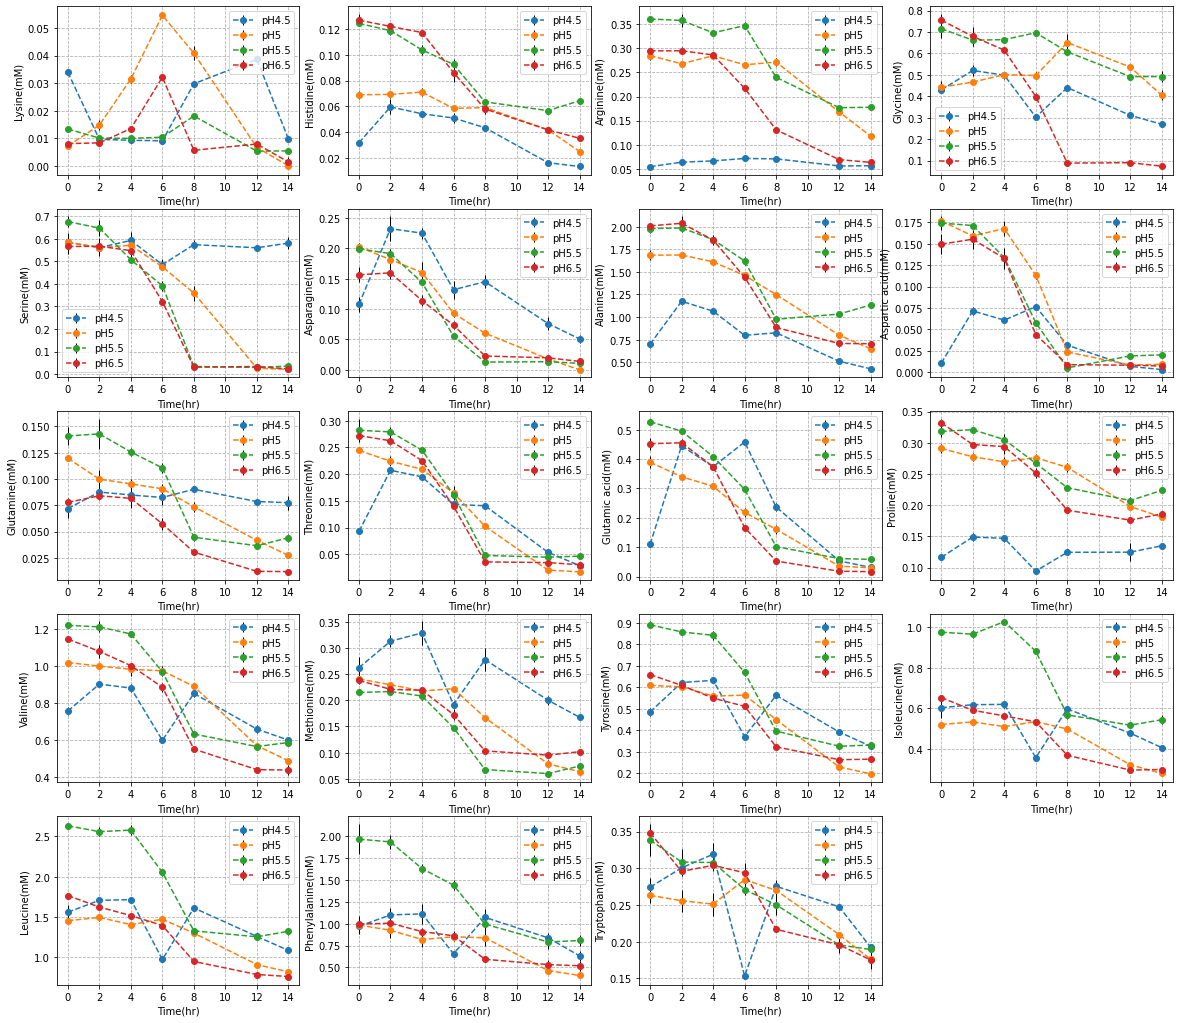

In [7]:
aa2plot = ['Lysine','Histidine', 'Arginine', 'Glycine', 'Serine', 'Asparagine', 'Alanine',
       'Aspartic acid', 'Glutamine', 'Threonine', 'Glutamic acid', 'Proline',
       'Valine', 'Methionine', 'Tyrosine', 'Isoleucine', 'Leucine',
       'Phenylalanine', 'Tryptophan']
conditions = ['pH4.5', 'pH5', 'pH5.5', 'pH6.5']
fig, axs = plt.subplots(5,4,figsize=(20,18))
for i in range(len(aa2plot)):
    x,y = int(i/4), int(i%4)
    temp_aa = aa2plot[i]
    profile = get_met_cons( temp_aa, metab)
    time = profile['Time']
    for cond in conditions:
        axs[x][y].errorbar( time, profile[cond+'_avg'], yerr= profile[cond+'_std'], ecolor='black',
                       marker='o', markersize=6, linestyle='--', elinewidth=1, label=cond )
    
    
    axs[x][y].grid(linestyle='--')
    axs[x][y].legend(); axs[x][y].set_xlabel('Time(hr)');
    axs[x][y].set_xticks(np.arange(0,16,2))
    axs[x][y].set_ylabel(temp_aa+'(mM)')
fig.delaxes(axs[4][3])

In [54]:
growth_free = pd.read_excel('../data/Exp_data/Growth_freepH.xlsx')
mass_avg = np.mean(growth_free.iloc[:,2:5].values, axis=1)*conv_factor
mass_std = np.std(growth_free.iloc[:,2:5].values, axis=1)*conv_factor
eps_avg = np.mean(growth_free.iloc[:,5:].values, axis=1)
eps_std = np.std(growth_free.iloc[:,5:].values, axis=1)
pH_list = list(growth_free['pH'])

# Intracellular metabolomics

In [ ]:
intra_metab = pd.read_csv('../data/Exp_data/IntraMetabolomics.csv')
temp_samples = []
for sample in list(intra_metab['Sample']):
    if sample == 'Free':
        temp_samples.append('Uncontrolled')
    else:
        temp_samples.append('pH='+str(sample) )    
intra_metab['Sample'] = temp_samples
intra_metabolites = ['3-Phosphoglyceric acid','Phosphoenolpyruvate','Pyruvic acid',
                     'Lactic acid','Acetic acid','Formic acid' ]

/home/bras5181/miniconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


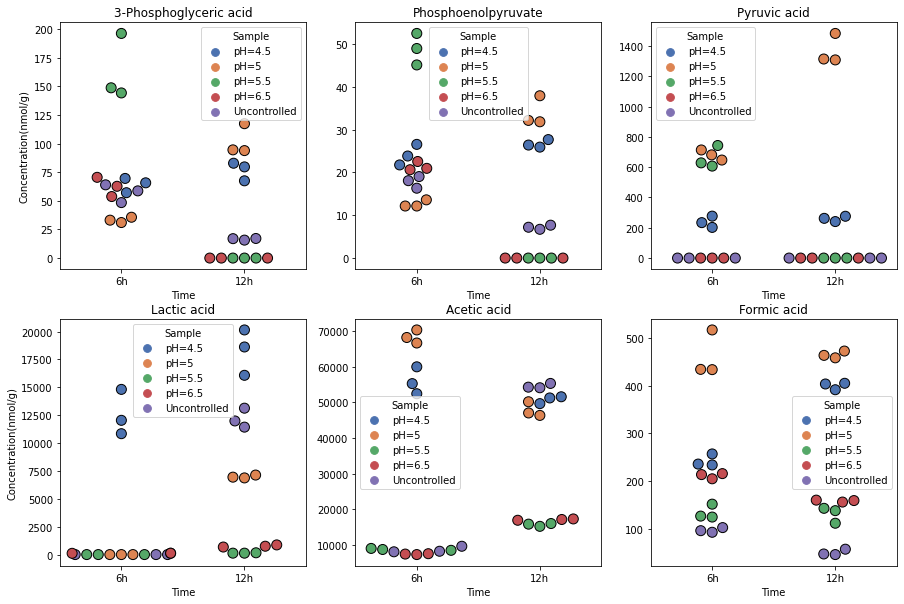

In [29]:
fig, axs = plt.subplots(2,3,figsize=(15,10))
for i in range(len(intra_metabolites)):
    met = intra_metabolites[i]
    x, y = int(i/3), int(i%3)
    sns.swarmplot(data=intra_metab,x='Time',y=met,hue='Sample',
                  size=10,edgecolor='black', linewidth=1,palette="deep",ax=axs[x][y])
    axs[x][y].set_title(met)
    if y==0:
        axs[x][y].set_ylabel('Concentration(nmol/g)')
    else:
        axs[x][y].set_ylabel('')
# plt.savefig('../../../../EPS_LP/Figures/intra_metab_plots.svg',format='svg',dpi=150)